In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, 
    roc_curve, auc, confusion_matrix, precision_recall_fscore_support, 
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from lightgbm import LGBMClassifier
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall
# pip install scikit-plot

In [2]:
%load_ext watermark

In [3]:
%watermark -vp numpy,pandas,sklearn,scikitplot,lightgbm,matplotlib

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.8.0

numpy     : 1.23.3
pandas    : 1.5.0
sklearn   : 1.2.2
scikitplot: 0.3.7
lightgbm  : 3.3.5
matplotlib: 3.7.1



### Data

Simulamos un dataset para clasificar entre 3 clases., y separamos en training y validation sets.

In [4]:
X, y = make_classification(
    n_samples=20_000, n_features=4, n_informative=4, n_redundant=0, n_classes=3,
    n_clusters_per_class=1, weights=[0.6, 0.1, 0.3], flip_y=0.05, class_sep=0.8, 
    random_state=18)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=33)

### Modelo

Usamos un clasificador LightGBM.

Ponderamos a las clases en la función de costos según su frecuencia en los datos, de modo tal que cada una tenga el mismo peso.

`objective="multiclass"` entrena un clasificador por clase y combina las predicciones con una función softmax. Esta es una estrategia bastante genérica que se conoce como "One-vs-All" o "One-vs-Rest".

En general existen distintas estrategias de entrenar clasificadores multi-clase y las posibilidades dependen de cada modelo específico. Ver por ejemplo [este post de sklearn](https://scikit-learn.org/stable/modules/multiclass.html). 

In [6]:
pd.Series(y).value_counts(normalize=True)

0    0.58685
2    0.30130
1    0.11185
dtype: float64

In [7]:
clf = LGBMClassifier(
    objective="multiclass", class_weight='balanced', n_jobs=2, random_state=99)

In [8]:
%%time
_ = clf.fit(X_train, y_train)

CPU times: total: 1.16 s
Wall time: 1.74 s


In [9]:
y_pred_proba = clf.predict_proba(X_val)
y_pred = y_pred_proba.argmax(axis=1)

In [10]:
y_pred_proba, y_pred

(array([[0.01101852, 0.04790754, 0.94107394],
        [0.68430199, 0.30955272, 0.0061453 ],
        [0.1665185 , 0.42388103, 0.40960047],
        ...,
        [0.92628775, 0.04285358, 0.03085867],
        [0.98711847, 0.01018808, 0.00269345],
        [0.98925851, 0.0030176 , 0.00772389]]),
 array([2, 0, 1, ..., 0, 0, 0], dtype=int64))

In [10]:
print(y_pred_proba[:2])
print(y_pred_proba[:2].sum(axis=1))

[[0.01101852 0.04790754 0.94107394]
 [0.68430199 0.30955272 0.0061453 ]]
[1. 1.]


### Métricas

Vamos a suponer que nuestra métrica objetivo es el F1. Sabemos cómo calcularlo para un problema de clasificación binaria. ¿Cómo podemos extenderlo a un problema de clasificación multiclase?

In [11]:
def binary_confusion_matrix(y_true, y_pred, label):
    y_true_ = y_true == label
    y_pred_ = y_pred == label
    plot_confusion_matrix(y_true_, y_pred_, figsize=(3, 3))
    plt.xlabel(f"Predicted {label}")
    plt.ylabel(f"True {label}")
    plt.title(f"Confusion Matrix for {label}")

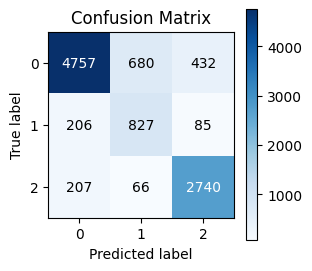

In [12]:
# matriz general
plot_confusion_matrix(y_val, y_pred, figsize=(3, 3))
plt.show()

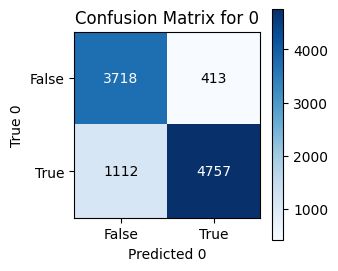

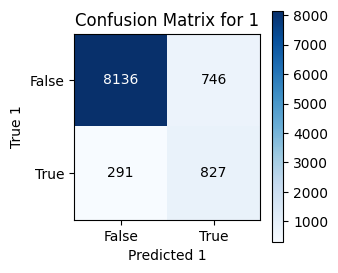

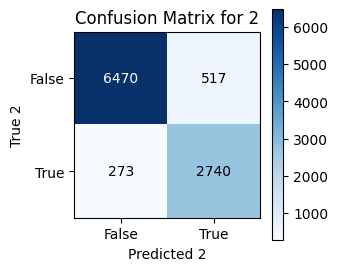

In [13]:
# matrix por clase
for i in range(y_pred_proba.shape[1]):
    binary_confusion_matrix(y_val, y_pred, i)
    plt.show()

Vamos a analizar dos maneras generales de combinar las métricas de cada clase:

* **macro-averaging**: promedio simple de las métricas de cada clase (por la frecuencia). 
* **macro-weighted averaging**: promedio ponderado de las métricas de cada clase (por la frecuencia). 

In [14]:
print(precision_recall_fscore_support(y_val, y_pred, average='macro'))

(0.7623760007375954, 0.819878769801781, 0.7834993385984537, None)


In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      5869
           1       0.53      0.74      0.61      1118
           2       0.84      0.91      0.87      3013

    accuracy                           0.83     10000
   macro avg       0.76      0.82      0.78     10000
weighted avg       0.85      0.83      0.84     10000



#### Métricas globales

Para AUROC, podemos calcular una versión "one-vs-rest" (OVR) por clase, usando el score de cada clase y "binarizando" el vector de target:

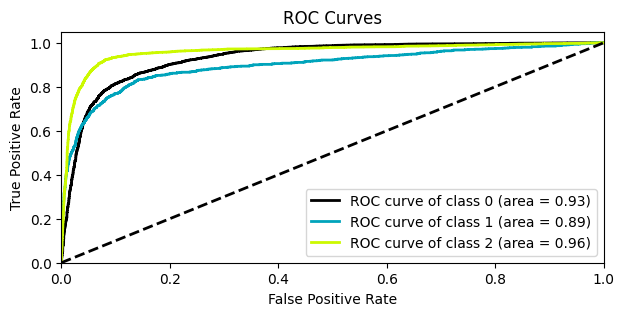

In [27]:
plot_roc(y_val, y_pred_proba, plot_micro=False, plot_macro=False, figsize=(7, 3))
plt.show()

Las métricas por clase se pueden combinar con distintos tipos de averaging (macro o weighted):

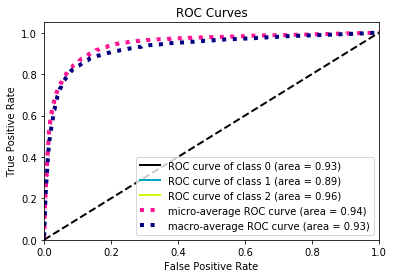

In [19]:
ax = plot_roc(y_val, y_pred_proba)
for i in range(y_pred_proba.shape[1]):
    ax.lines[0].remove()
plt.show()

In [16]:
print(f"AUROC ovr macro = {roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='macro'):.4f}")
print(f"AUROC ovr weighted = {roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted'):.4f}")

AUROC ovr macro = 0.9277
AUROC ovr weighted = 0.9348


In [20]:
# OJALDRE con el micro AUROC (hace una cuenta rara, por las dudas no lo usen:)
def auroc_ovr_micro(y_true, y_pred):
    """Version interna de scikit-plot. USE WITH CARE!
    """
    binarized_y = label_binarize(y_true, classes=np.unique(y_true))
    fpr, tpr, _ = roc_curve(binarized_y.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc

print(f"AUROC ovr micro (OJO!) = {auroc_ovr_micro(y_val, y_pred_proba):.4f}")

También existen versiones que toman promedios de AUROCs "one-vs-one" (OVO) por clase. En general la versión OVO + weighted se considera un buen default. Sugerimos leer:

* https://scikit-learn.org/stable/modules/model_evaluation.html#multi-class-case
* https://yardstick.tidymodels.org/articles/multiclass.html

In [17]:
print(f"AUROC ovo weighted = {roc_auc_score(y_val, y_pred_proba, multi_class='ovo', average='weighted'):.4f}")

AUROC ovo weighted = 0.9255


También hay maneras diversas de promediar el AUPRC. Sugerimos considerar las versiones macro y weighted como en [`yardstick`](https://yardstick.tidymodels.org/reference/pr_auc.html#multiclass).

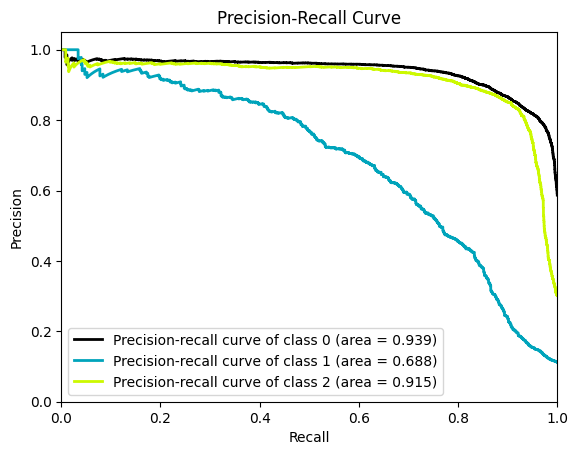

In [18]:
plot_precision_recall(y_val, y_pred_proba, plot_micro=False)
plt.show()

In [19]:
def auc_pr(y_true, y_pred, average="macro"):
    binarized_y = label_binarize(y_true, classes=np.unique(y_true))
    scores = []
    for i in range(y_pred.shape[1]):
        score_ =  average_precision_score(binarized_y[:, i], y_pred[:, i])
        scores.append(score_)
    if average == "macro":
        weights = np.array([1, 1, 1])
    elif average == "weighted":
        weights = np.sum(binarized_y, axis=0)
    return np.average(scores, weights=weights)    

In [20]:
print(f"AUPRC macro = {auc_pr(y_val, y_pred_proba, average='macro'):.4f}")
print(f"AUPRC weighted = {auc_pr(y_val, y_pred_proba, average='weighted'):.4f}")

AUPRC macro = 0.8473
AUPRC weighted = 0.9039


--------------------------------------

Resumiendo: 

* metricas globales
    * auroc (simetrico)
    * auprc (asimetrico / para una clase)
      * Extension multiclase: promediar metricas binarias (OvO o OvR, macro average o macro-weighted avg)
* metricas de clf
    * accuracy (simetrico y balanceados), precision, recall
    * costo (general)
    * f-score (asimetrico / para una clase)
    * macro f1, MCC, balanced accuracy (simetrico y desbalanceado)
        * Extension multiclase --> promediar metricas binarias (macro average o macro-weighted avg)

----------------------------------